In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
from scipy.stats import norm

### Global parameters

In [2]:
# Number of market participants 
N = 1600 

# Number of fundamentalists, chartists and random traders
N_FUND = 720
N_CHART = 720
N_RANDOM = 160

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2

# Sensitivity of forecasts for chartists 
KAPPA = 2

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Information Threshhold
Ith = 1

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

In [3]:
# Function to calculate expected price for one fundamentalist
def ep_fundamentalist(p_t, P_F):
    """
    Calculate the expected price for a fundamentalist trader

    Parameters:
    p_t (float): The current market price of the asset
    p_f (float): The perceived fundamental price of the asset for the trader

    Returns:
    float: The expected price for the asset for a fundamentalist trader
    """
    noise = np.random.uniform(-SIGMA, SIGMA)
    # Was not too sure about using an uniform or normal distribution here
    p_f = np.random.uniform(P_F - THETA, P_F + THETA)
    ep = p_t + PHI * (p_f - p_t) + noise
    if ep < 0:
        return 0
    return ep

# Function to calculate expected price for one chartist
def ep_chartist(p_t, past_prices):
    """
    Calculate the expected price for a chartist trader

    Parameters:
    p_t (float): The current market price of the asset
    past_prices (list of float): A list of past market prices of the asset

    Returns:
    float: The expected price for the asset as calculated by a chartist trader
    """
    assert len(past_prices) == T_MAX, "past_prices must be a list of 15 values"
    chartist_T = np.random.randint(2, T_MAX)
    p_T = np.mean(past_prices[-chartist_T:]) 
    noise = np.random.uniform(-SIGMA, SIGMA)
    ep = p_t + KAPPA/(chartist_T) * (p_t - p_T) + noise
    if ep < 0:
        return 0
    return ep

# Function that determines the choice one random trader makes
def rand_trader(money, asset_quantity):
    choice = random.choice(['buy', 'sell', 'hold'])
    if choice == 'buy' and money > 0:
        return 'buy'
    elif choice == 'sell' and asset_quantity > 0:
        return 'sell'
    else:
        return 'hold'
    

### 

In [4]:
# Function to calculate the order type for a non-random trader
def determine_order_type(expected_price, p_t, TAO, money, asset_quantity):
    """
    Determine the order type of a trader based on the expected price, current price,
    sensitivity threshold, available money, and asset quantity

    Parameters:
    expected_price (float): The expected price of the asset
    p_t (float): The current market price of the asset
    TAO (int): The threshold to decide whether to hold
    money (float): The amount of money the trader has
    asset_quantity (int): The quantity of the asset the trader holds

    Returns:
    str: The order type ('buy', 'sell', or 'hold')
    """

    if expected_price > p_t + TAO:
        if money > 0:
            return "buy"  # Buy the asset (bidder)
    elif expected_price < p_t - TAO:
        if asset_quantity > 0:
            return "sell"  # Sell the asset (asker)
    else:
        return "hold"  # Hold without setting any orders

def set_order_price(order_type, expected_price, current_price, money):
    """
    Set the order price for a trader based on their order type, expected price,
    current price, and the amount of money they have

    Parameters:
    order_type (str): The type of order ('buy', 'sell', or 'hold')
    expected_price (float): The expected price of the asset
    current_price (float): The current market price of the asset
    money (float): The amount of money the trader has
    
    Returns:
    float: The price set for the order
    """
    if order_type == 'buy':
        order_price = np.random.uniform(0, min(money, expected_price))
        if order_price < 0:
            return 0
        else:
            return order_price
    elif order_type == 'sell':
        order_price = np.random.uniform(expected_price, current_price)
        if order_price < 0:
            return 0
        else:
            return order_price
    else:
        return 0
    
def set_order_price_random(order_type, current_price, money):
    if order_type == 'buy':
        return np.random.uniform(0, min(money, current_price+50))
    elif order_type == 'sell':
        return np.random.uniform(current_price, current_price-50)
    else:
        return 0

In [5]:
# Example usage
current_market_price = P_0
trader_money = M
trader_asset_quantity = Q

ep = ep_fundamentalist(current_market_price, P_F) 
order_type = determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity)
order_price = set_order_price(order_type, ep, current_market_price, trader_money)

print(ep)
print(order_type)
print(order_price)

108.82059004719407
hold
0


In [6]:
class OrderBook:
    def __init__(self, delta, agents_dict):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
        self.bids = []  # List to store bid orders
        self.asks = []  # List to store ask orders
        self.delta = delta  # Parameter for price adjustment
        self.N_a = 0
        self.N_b = 0
        self.N_T = 0
        self.agents_dict = agents_dict
    
        
    def place_bid(self, trader_id, price):
        """
        Place a bid order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the bid.
        - price (float): Bid price.
        """
        self.bids.append({'trader_id': trader_id, 'price': price})
        self.N_b += 1  # Increment the number of bidders
        
    def place_ask(self, trader_id, price):
        """
        Place an ask order in the order book.

        Parameters:
        - trader_id (int): ID of the trader placing the ask.
        - price (float): Ask price.
        """
        self.asks.append({'trader_id': trader_id, 'price': price})
        self.N_a += 1  # Increment the number of askers
        


    def match_orders(self):
        """
        Match bid and ask orders in the order book.

        Returns:
        - list: List of dictionaries representing matched transactions.
        """
        
        N_T = 0 
        
        while self.bids and self.asks:
            best_bid = self.bids[0]
            best_ask = self.asks[0]
            
            if best_bid['price'] >= best_ask['price']:
                # Remove matched orders
                p_L = self.asks[0]['price']
                self.agents_dict[self.asks[0]['trader_id']][3] -= 1 ## assets
                self.agents_dict[self.bids[0]['trader_id']][3] += 1 
                self.agents_dict[self.asks[0]['trader_id']][2] += p_L  
                self.agents_dict[self.bids[0]['trader_id']][2] -= p_L
                self.bids.pop(0)
                self.asks.pop(0)
                self.N_b -= 1
                self.N_a -= 1
                N_T += 1    
            else:
                break  # No more possible transactions
        if self.N_b > self.N_a:
            return N_T, p_L
        else:
            p_L = self.asks[0]['price']
            return N_T, p_L
        

    def set_aggregate_price(self, prev_price):
        """
        Set the aggregate asset price at time t + 1 based on different cases.

        Parameters:
        - prev_price (float): Previous global asset price at time t.
        - N_a (int): Number of askers in the order book.
        - N_b (int): Number of bidders in the order book.

        Returns:
        - float: New global asset price at time t + 1.
        """
        
        self.bids.sort(key=lambda x: x['price'], reverse=True)
        self.asks.sort(key=lambda x: x['price'])
        

        if self.N_a == 0 and self.N_b > 0:
            new_price = prev_price + self.delta * self.N_b
        elif self.N_a > 0 and self.N_b == 0:
            new_price = prev_price - self.delta * self.N_a
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] < self.asks[0]['price']:
            new_price = prev_price + self.delta * self.N_b
        elif 0 < self.N_a < self.N_b and self.bids[0]['price'] > self.asks[0]['price']:
            N_T,p_L = self.match_orders()
            new_price = p_L + self.delta * (self.N_b - N_T)
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] <= self.asks[0]['price']:
            new_price = prev_price - self.delta * self.N_a
        elif 0 < self.N_b < self.N_a and self.bids[0]['price'] > self.asks[0]['price']:
            N_T, p_L = self.match_orders()
            new_price = p_L - self.delta * (self.N_a - N_T)
        else:
            new_price = prev_price
        self.N_a = 0
        self.N_b = 0
        self.bids = []
        self.asks = []
        return new_price


## NETWORK PART

In [7]:
def create_lattice_small_world_network():
    n = 40 # Size of the lattice (n x n)
    k = 4   # Each node is connected to its k nearest neighbors
    p = 0.02 # Probability of rewiring each edge

    # Create a 2D square lattice
    lattice = nx.grid_2d_graph(n, n)

    # Rewire edges with probability p while preserving node degrees
    for edge in list(lattice.edges()):
        if random.random() < p:
            u, v = edge
            possible_edges = [(u, w) for w in lattice if w != v and not lattice.has_edge(v, w)]
            if possible_edges:
                new_v = random.choice(possible_edges)[1]
                lattice.remove_edge(u, v)
                lattice.add_edge(u, new_v)
    return lattice

In [15]:
class Network:
    
    def __init__(self, alpha, agents_dict, network):
        """
        Initialize the OrderBook with the given delta value.

        Parameters:
        - delta (float): Parameter for price adjustment.
        """
    
        self.agents_dict = agents_dict # Dictionary containing each agents and information
        self.network = network 
        self.state_counts = {'buy': [], 'sell': [], 'hold': []}
        self.info_counts = []
        self.alpha = alpha
        self.Ith = Ith
        self.trade_counts = [] # Keep track of amount of trades per simulation
        
    def propagate_info(self, agent_index):
        """
        Propagate information of an agent to its neighbors in the network.

        Parameters:
        - agent_index (int): The index of the agent in the agents dictionary.
        """
        agent = self.agents_dict[agent_index]
        agent_coord = (agent_index // 40, agent_index % 40)  # Map index to coordinates
        neighbors_coords = list(self.network.neighbors(agent_coord))
        if agent[6] >= self.Ith:  # Check if agent's information exceeds the threshold
            self.info_counts[-1] += 1
            store_info = agent[6]
            self.agents_dict[agent_index][6] = 0  # Reset agent's information
            for neighbor_coord in neighbors_coords:
                neighbor_index = neighbor_coord[0] * 40 + neighbor_coord[1]  # Map coordinates to index
                self.agents_dict[neighbor_index][5] = agent[5]   # Propagate decision to neighbor
                self.agents_dict[neighbor_index][4] = agent[4]
                self.agents_dict[neighbor_index][7] = agent[7]
                self.agents_dict[neighbor_index][6] += (self.alpha / len(neighbors_coords)) * store_info
                self.agents_dict[neighbor_index][6] = min(self.agents_dict[neighbor_index][6], np.finfo(float).max)
                if self.agents_dict[neighbor_index][6] >= self.Ith:
                    self.propagate_info(neighbor_index)  # Recursive call

    def network_cycle(self):
        """
        Update the network for one simulation cycle and collect information for future plots.
        """
        self.info_counts.append(0)  # Reset agent information threshold crossing counter
        copy_agents = self.agents_dict.copy()
        # Add global information
        for agent_id in self.agents_dict:
            self.agents_dict[agent_id][6] += np.random.uniform(0, (self.Ith - max([copy_agents[agent_id][6] for agent_id in copy_agents])))
        # Contagion mechanism
        for i, _ in enumerate(self.agents_dict):
            self.propagate_info(i)

### Simulation

In [16]:
# Initialize agent attributes at T = 0

# structure of agent data
# agents = np.zeros(N, dtype=[('type', 'U10'),# 0
#                             ('wealth', 'f8'),# 1
#                             ('money', 'f8'), # 2
#                             ('assets', 'f8'), # 3
#                             ('expected_price', 'f8'), # 4
#                             ('decision', 'U10'), # 5
#                             ('info', 'f8')]) # 6
#                             ('order price') # 7

agents_dict = {}
past_price = [P_0 for i in range(T_MAX)]
for i in range(800):
    ep = ep_fundamentalist(P_0, P_F)
    #print(ep) 
    agents_dict[i] = ['fund',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, M, Q),
                 np.random.uniform(0, Ith),
                 0
                 ]

# # Start from where N_FUND stops for integers
for i in range(800, 1600):
    ep = ep_chartist(P_0, past_price)
    agents_dict[i] = ['chart',
                 W[i],
                 M,
                 Q,
                 ep,
                 determine_order_type(ep, P_0, TAO, trader_money, trader_asset_quantity),
                 np.random.uniform(0, Ith),
                 0
                 ]

for agent_id in agents_dict:
    decision = agents_dict[agent_id][5]
    order_price = set_order_price(decision, agents_dict[agent_id][4], P_0, agents_dict[agent_id][2])
    agents_dict[agent_id][7] = order_price

In [17]:
network = create_lattice_small_world_network()
ob = OrderBook(DELTA, agents_dict)
nw = Network(ALPHA, ob.agents_dict, network)

In [18]:
# for cycle in range(10000):
#     print(cycle)
#     nw.network_cycle()

In [19]:
import pickle

# with open('nw_object.pkl', 'wb') as file:
#     pickle.dump(nw, file)
    
with open('nw_object.pkl', 'rb') as input_file:
    nw = pickle.load(input_file)

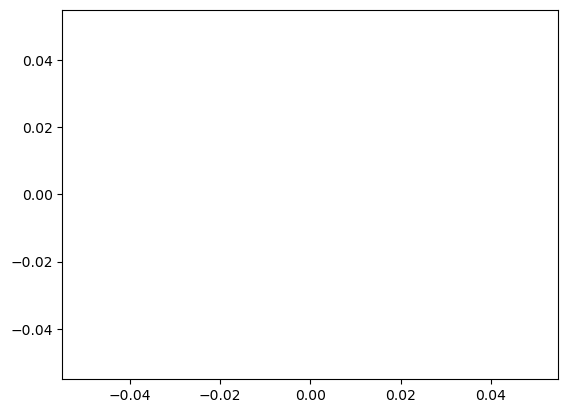

In [39]:
plt.plot(range(len(nw.info_counts)), nw.info_counts)

In [21]:
# Simulation 1 cycle
#ob = OrderBook(DELTA, agents_dict)
current_market_price = P_0
simulations = 9000
asset_prices = []
# Check #5, decision in dict to get decision
for sim in range(simulations):
    ob.agents_dict = nw.agents_dict # Send Network agents_dict to Orderbook
    for agent_id in ob.agents_dict:
        decision = ob.agents_dict[agent_id][5]
        order_price = ob.agents_dict[agent_id][7]
        if decision == "buy":
            ob.place_bid(agent_id, order_price)
        elif decision == "sell":
            ob.place_ask(agent_id, order_price)
    current_market_price = ob.set_aggregate_price(current_market_price)
    asset_prices.append(current_market_price)
    past_price.pop(0)
    past_price.append(current_market_price)
    
    for agent_id in range(800): 
        ep = ep_fundamentalist(current_market_price, P_F) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    for agent_id in range(800, 1600):
        ep = ep_chartist(current_market_price, past_price) 
        ob.agents_dict[agent_id][4] = ep
        ob.agents_dict[agent_id][5] = determine_order_type(ep,
                                                    current_market_price, 
                                                    TAO, ob.agents_dict[agent_id][2],
                                                    ob.agents_dict[agent_id][3])
    
   
    nw = Network(ALPHA, ob.agents_dict, network)
    nw.network_cycle()

In [27]:
money = []
zeros = 0
for agent_id in ob.agents_dict:
    money.append(ob.agents_dict[agent_id][2])
    if ob.agents_dict[agent_id][3] == 0:
        print(ob.agents_dict[agent_id][0])
        zeros += 1
print(zeros)

fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund
fund


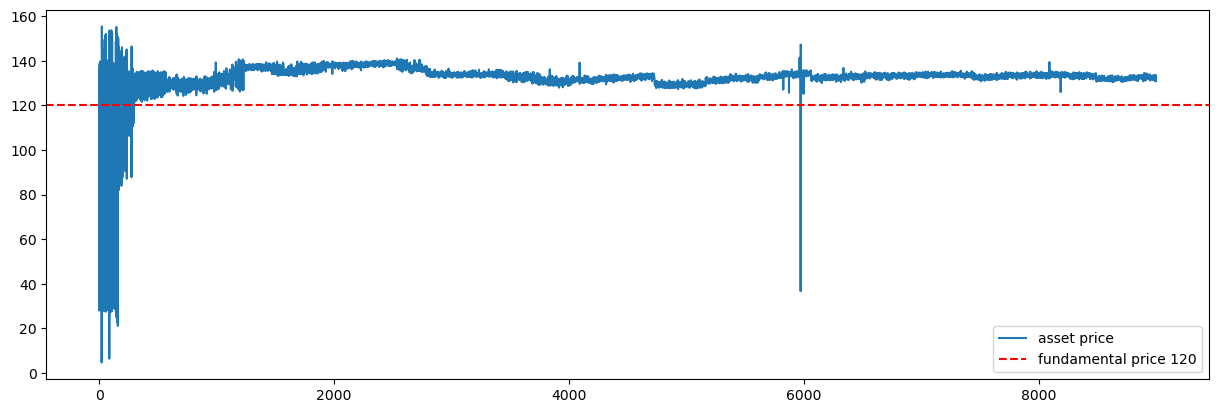

In [28]:
plt.figure().set_figwidth(15)
plt.plot(list(range(len(asset_prices))), asset_prices, label ='asset price')
plt.axhline(y=120, color='r', linestyle='--', label='fundamental price 120')
plt.legend()

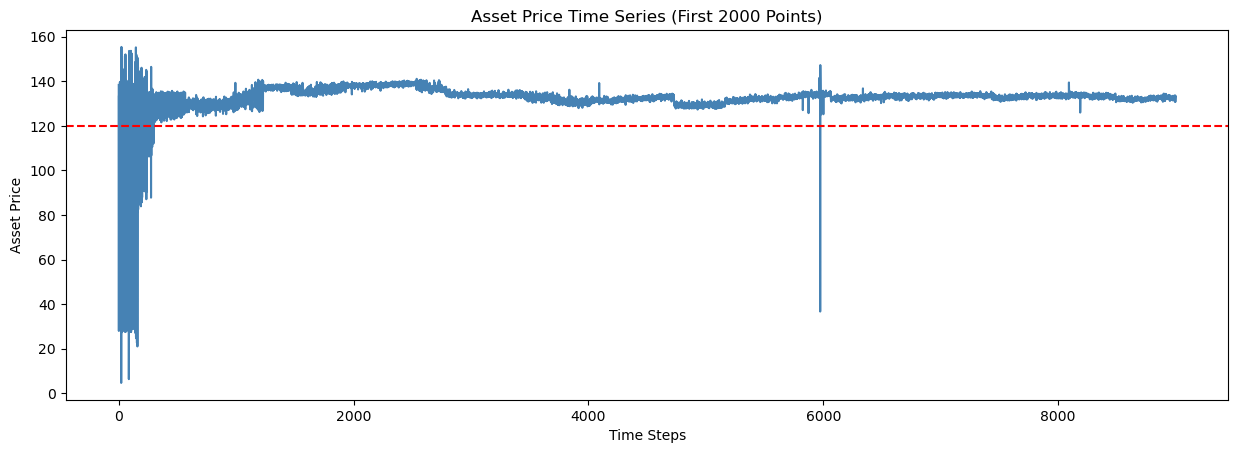

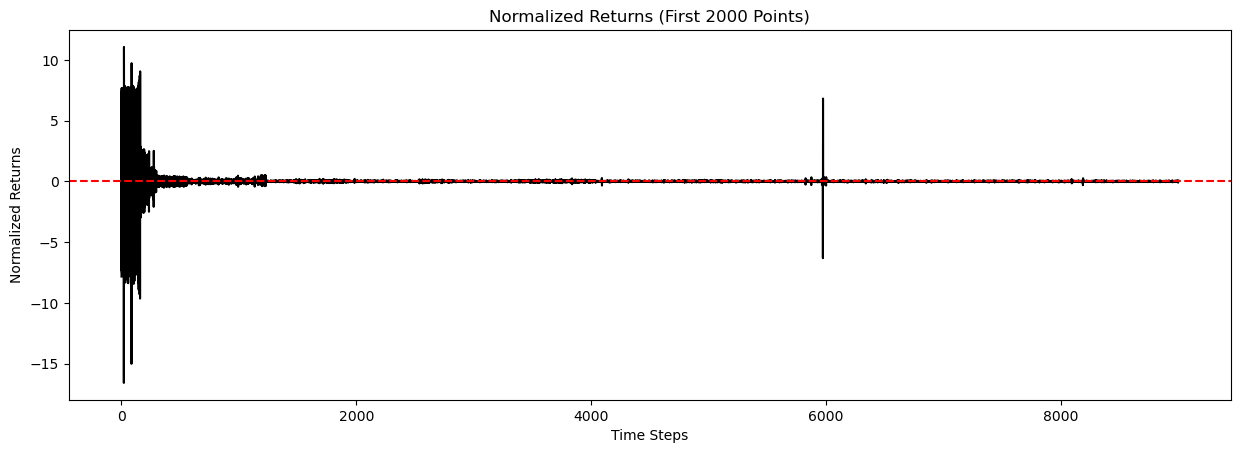

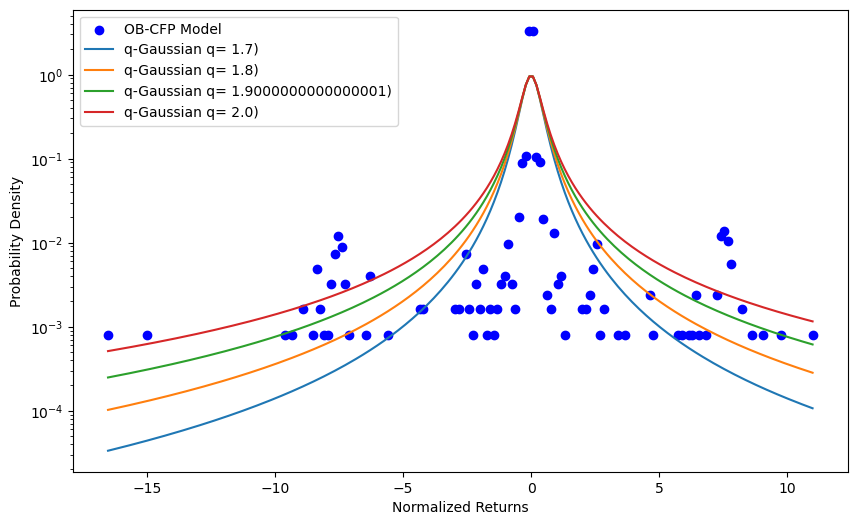

In [38]:
# Use the first 2000 data points
asset_prices_subset = asset_prices

# Calculate returns rt
rt = np.log(asset_prices_subset[1:]) - np.log(asset_prices_subset[:-1])

# Calculate average return and standard deviation
r_avg = np.mean(rt)
r_stdev = np.std(rt)

# Calculate normalized returns r^NORM
r_norm = (rt - r_avg) / r_stdev

# Plot the asset price time series
plt.figure().set_figwidth(15)
plt.plot(asset_prices_subset, color='steelblue')
plt.axhline(y=120, color='r', linestyle='--')
plt.title('Asset Price Time Series (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Asset Price')
plt.show()

# Plot the normalized returns time series
plt.figure().set_figwidth(15)
plt.plot(r_norm, color='black')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Normalized Returns (First 2000 Points)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Returns')
plt.show()

# Calculate the probability density function (PDF) of the normalized returns
counts, bin_edges = np.histogram(r_norm, bins=200, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot the PDF of the normalized returns
plt.figure(figsize=(10, 6))
plt.scatter(bin_centers, counts, label='OB-CFP Model', color='blue')

# Fit a Gaussian distribution
# params_norm = norm.fit(r_norm)
# pdf_gaussian = norm.pdf(bin_centers, *params_norm)
# plt.plot(bin_centers, pdf_gaussian, label='Gaussian', linestyle='--', color='steelblue')

# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Parameters for the q-Gaussian
A = 0.98
B = 7
q_list = np.arange(1.7, 2.0, 0.1)


# Plot the q-Gaussian
for q in q_list:
    plt.plot(bin_centers, q_gaussian(bin_centers, A, B, q), label=f'q-Gaussian q= {q})')

plt.yscale('log')
plt.xlabel('Normalized Returns')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [31]:
# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Parameters for the q-Gaussian
A = 0.98
B = 7

In [32]:
import numpy as np
from scipy.optimize import minimize

# Data provided
data = np.array(bin_centers)

# Definition of the q-Gaussian function
def q_gaussian(x, A, B, q):
    return A * np.power(1 - (1 - q) * B * x**2, 1 / (1 - q))

# Negative log likelihood function
def negative_log_likelihood(params):
    A, B, q = params
    likelihood = np.sum(np.log(q_gaussian(data, A, B, q)))
    return -likelihood

# Initial parameter guesses
initial_guess = [0.98, 7, 1.5]

# Minimize the negative log likelihood
result = minimize(negative_log_likelihood, initial_guess, bounds=[(0, None), (0, None), (1, 3)])

# Extract the best fitting parameters
A_fit, B_fit, q_fit = result.x

A_fit, B_fit, q_fit



(9390543.031917926, 0.0, 3.0)